In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
from datetime import datetime

# read the cleaned data
data = pd.read_csv("ProcessedData_.csv")

#drop car brand names
data_rm_brand = data.drop(['Listing ID','Brand', 'Listing URL'], axis=1)

#change car Registration Dates str type to datetime type
data_rm_brand['Registration Date'] = pd.to_datetime(data['Registration Date'])
data_rm_brand['Registration Date'].dtypes

#encode Transmission (Auto='1', Manual='0')
#Define a mapping dictionary
mapping_dict = {'Auto': 1, 'Manual': 0}

# Apply the mapping to the "Transmission" column
data_rm_brand['Transmission'] = data_rm_brand['Transmission'].map(mapping_dict)

#Rename the column to 'Transmission' to reflect encoding
data_rm_brand.rename(columns={'Transmission': 'Transmission'}, inplace=True)

#encode car types
# Define a mapping dictionary
mapping_dict2 = {'Hatchback': 1,'Mid-Sized Sedan': 2, 'MPV': 3, 'Luxury Sedan': 4, 'SUV': 5, 'Sports Car': 6, 'Stationwagon': 7}

# Apply the mapping to the "Vehicle Type" column
data_rm_brand['Vehicle Type'] = data_rm_brand['Vehicle Type'].map(mapping_dict2)

#Rename 'Vehicle Type' to reflect encoding
data_rm_brand.rename(columns={'Vehicle Type': 'Vehicle Type'}, inplace=True)

data_rm_brand.head()

,Price,Depreciation,Road Tax,Registration Date,COE Left,Mileage,Manufacture Year,Transmission,Deregistration,OMV,ARF,COE Price,Engine Capacity,Power,Curb Weight,No. Of Owners,Vehicle Type
0,199900,27820,1202,2019-11-01,2198,60000,2018,1,72477,50492,62886,41805,1991,155.0,1785,1,5
1,111888,13890,742,2021-08-27,2558,68825,2021,1,39332,18936,5000,45189,1598,90.2,1280,4,2
2,1088,102070,3552,2022-07-22,3198,5000,2022,1,361261,229837,385707,82001,3745,478.0,1715,1,6
3,98800,26060,2382,2015-06-26,607,123000,2014,1,72078,76072,108930,71509,2996,190.0,1790,2,4
4,51800,14760,738,2016-11-15,1126,95000,2016,1,24305,12352,12352,52668,1591,93.8,1345,2,2


In [130]:
# Convert the Series object to a datetime object using the `to_datetime()` function.
registration_date_datetime = pd.to_datetime(data_rm_brand['Registration Date'], format='%y-%m-%d')

# Encode the registration date to an integer.
encoded_registration_date = registration_date_datetime.dt.year * 10000 + registration_date_datetime.dt.month * 100 + registration_date_datetime.dt.day

print(encoded_registration_date)
encoded_registration_date = encoded_registration_date.astype(int)


0       20191101
1       20210827
2       20220722
3       20150626
4       20161115
          ...   
2907    20160526
2908    20180124
2909    20150413
2910    20181130
2911    20100115
Name: Registration Date, Length: 2912, dtype: int32


In [131]:
data_rm_brand.corr()

,Price,Depreciation,Road Tax,Registration Date,COE Left,Mileage,Manufacture Year,Transmission,Deregistration,OMV,ARF,COE Price,Engine Capacity,Power,Curb Weight,No. Of Owners,Vehicle Type
Price,1.000000,0.519554,0.468255,0.281180,0.478230,-0.436994,0.246775,-0.017386,0.467164,0.573699,0.577893,0.233610,0.516383,0.659910,0.400411,-0.042161,0.346372
Depreciation,0.519554,1.000000,0.545834,0.127656,0.071662,-0.258428,0.118615,-0.035924,0.732096,0.760295,0.795023,0.263053,0.612357,0.669362,0.421769,-0.004980,0.277822
Road Tax,0.468255,0.545834,1.000000,-0.289583,0.181776,0.010387,-0.267585,-0.036389,0.428684,0.818891,0.732061,0.201463,0.954977,0.836676,0.606028,0.321039,0.353460
Registration Date,0.281180,0.127656,-0.289583,1.000000,0.316805,-0.753075,0.908926,0.140531,0.365995,-0.010146,0.056784,0.199947,-0.163171,-0.042918,0.019355,-0.658748,0.021266
COE Left,0.478230,0.071662,0.181776,0.316805,1.000000,-0.444642,0.263695,-0.040798,0.352643,0.238600,0.205914,0.107509,0.150107,0.212957,0.064327,-0.047905,0.162079
Mileage,-0.436994,-0.258428,0.010387,-0.753075,-0.444642,1.000000,-0.691777,-0.089544,-0.413222,-0.208257,-0.236211,-0.229128,-0.055104,-0.159810,-0.052792,0.482664,-0.095027
Manufacture Year,0.246775,0.118615,-0.267585,0.908926,0.263695,-0.691777,1.000000,0.159170,0.341310,-0.007213,0.052225,0.204019,-0.193179,-0.049345,0.006488,-0.615961,-0.005680
Transmission,-0.017386,-0.035924,-0.036389,0.140531,-0.040798,-0.089544,0.159170,1.000000,-0.002007,0.001907,-0.010823,0.037557,-0.016310,-0.042956,0.081495,-0.120310,-0.078509
Deregistration,0.467164,0.732096,0.428684,0.365995,0.352643,-0.413222,0.341310,-0.002007,1.000000,0.736956,0.741462,0.404309,0.523313,0.597219,0.458632,-0.160256,0.255878
OMV,0.573699,0.760295,0.818891,-0.010146,0.238600,-0.208257,-0.007213,0.001907,0.736956,1.000000,0.900718,0.297178,0.830766,0.836963,0.547751,0.142614,0.344800


In [132]:
# How each feature relates to price
data_rm_brand.corr()['Price'].sort_values(ascending=False)

Price                1.000000
Power                0.659910
ARF                  0.577893
OMV                  0.573699
Depreciation         0.519554
Engine Capacity      0.516383
COE Left             0.478230
Road Tax             0.468255
Deregistration       0.467164
Curb Weight          0.400411
Vehicle Type         0.346372
Registration Date    0.281180
Manufacture Year     0.246775
COE Price            0.233610
Transmission        -0.017386
No. Of Owners       -0.042161
Mileage             -0.436994
Name: Price, dtype: float64

(17.5, -0.5)

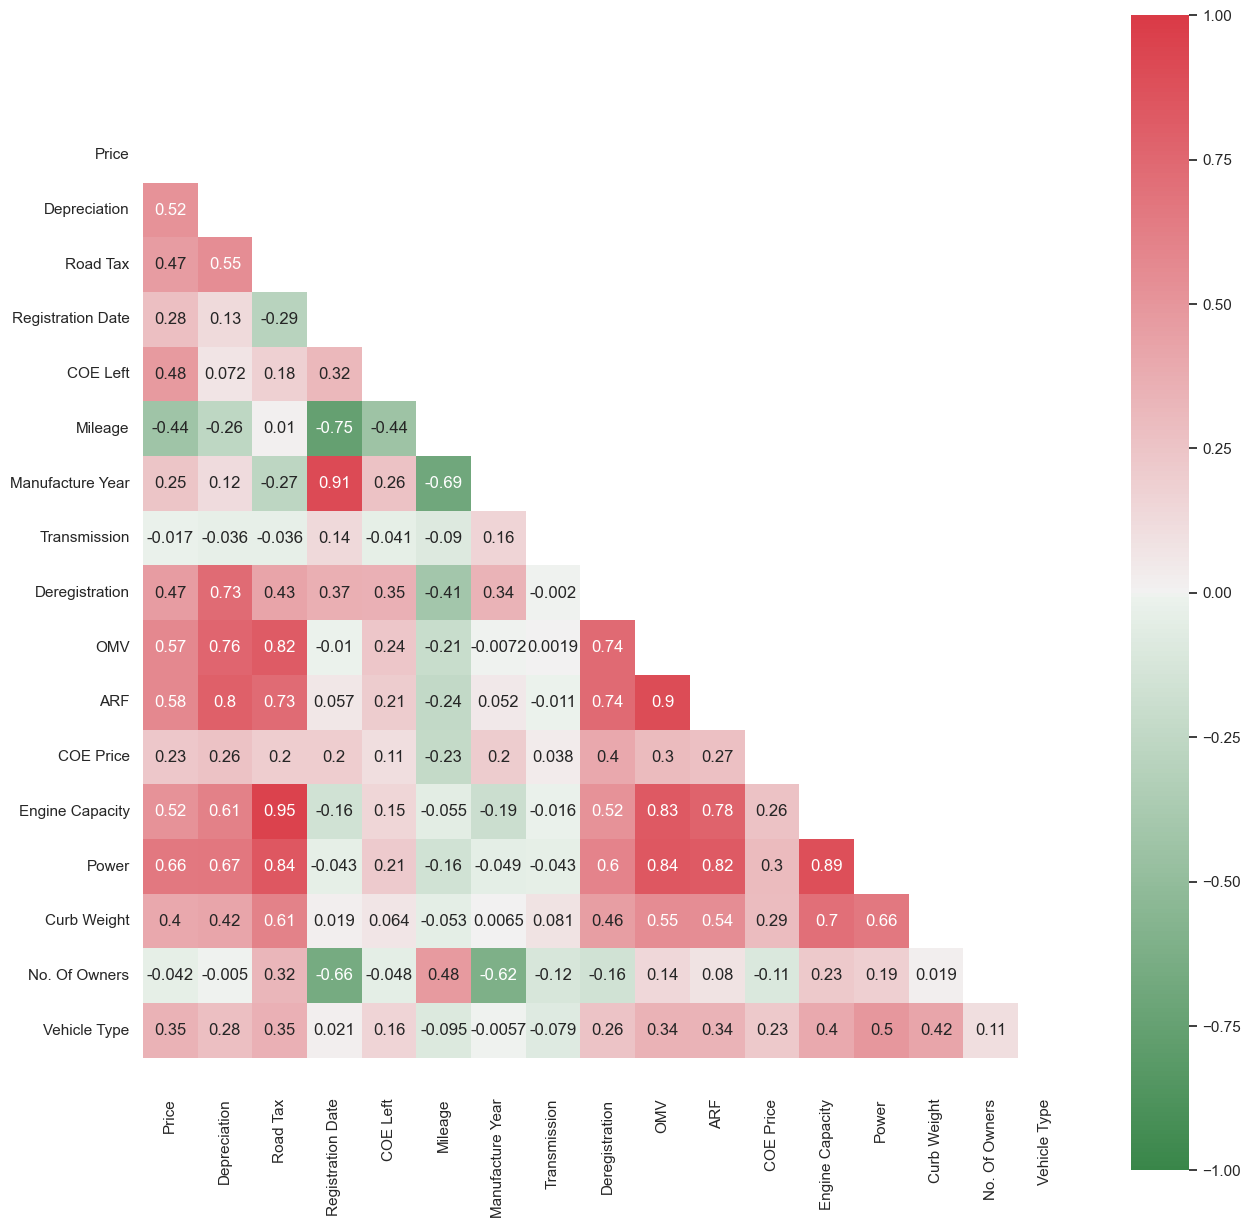

In [133]:
# Corr Matrix Heatmap Visualization

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data_rm_brand.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(data_rm_brand.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


In [134]:
# Drop the unwanted columns
data_rm_brand.drop(['Depreciation','Registration Date','Manufacture Year','ARF','Engine Capacity','Power'],axis=1,inplace=True)

# Get the remaining columns
remaining_columns = data_rm_brand.columns

# Save the remaining columns to a CSV file
data_rm_brand.to_csv('remaining_columns.csv', index=False, columns=remaining_columns)

In [135]:
print("Remaining columns after dropping high-correlation variables:")
print(data_rm_brand.columns)

Remaining columns after dropping high-correlation variables:
Index(['Price', 'Road Tax', 'COE Left', 'Mileage', 'Transmission',
       'Deregistration', 'OMV', 'COE Price', 'Curb Weight', 'No. Of Owners',
       'Vehicle Type'],
      dtype='object')


In [136]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Assuming X is your feature data and y is your target variable
data_rm_brand = pd.read_csv('remaining_columns.csv')

# Split the data into input features (X) and target variable (y)
X = data_rm_brand
y = data_rm_brand['Price']

# RFE for XGBoost
xgb_model = XGBRegressor()
rfe_xgb = RFE(estimator=xgb_model, n_features_to_select=10)  # Adjust the number of features to select as needed
rfe_xgb.fit(X, y)
selected_features_xgb = X.columns[rfe_xgb.support_]

# RFE for Linear Regression
lr_model = LinearRegression()
rfe_lr = RFE(estimator=lr_model, n_features_to_select=10)  # Adjust the number of features to select as needed
rfe_lr.fit(X, y)
selected_features_lr = X.columns[rfe_lr.support_]

# RFE for RandomForest
rf_model = RandomForestRegressor()
rfe_rf = RFE(estimator=rf_model, n_features_to_select=10)  # Adjust the number of features to select as needed
rfe_rf.fit(X, y)
selected_features_rf = X.columns[rfe_rf.support_]

# Combine selected features from all models (intersection)
selected_features = list(set(selected_features_xgb) & set(selected_features_lr) & set(selected_features_rf))

# Create a new dataset with selected features by ML model
selected_X = X[selected_features]

selected_X.to_csv('MLselected_columns.csv', index=False, columns=selected_X)

print("Remaining columns after ML selected dropping high-correlation variables:")
print(selected_X.columns)

Remaining columns after ML selected dropping high-correlation variables:
Index(['COE Left', 'COE Price', 'No. Of Owners', 'Curb Weight', 'Mileage',
       'OMV', 'Price', 'Road Tax'],
      dtype='object')


(8.5, -0.5)

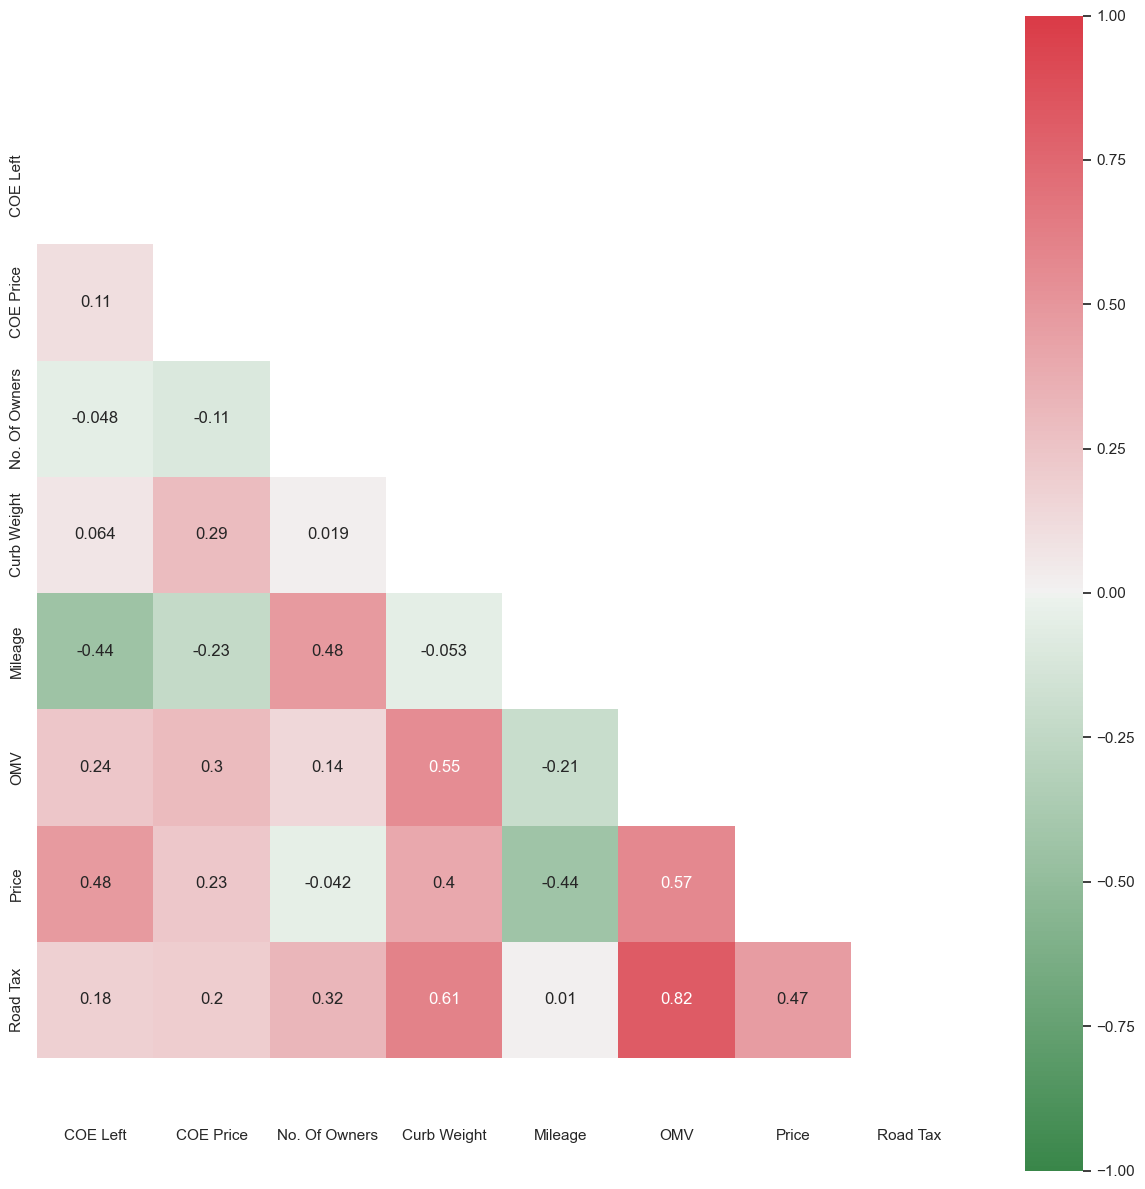

In [137]:
# Re-visualizing the correlation matrix
sns.set(style="white")
# Creating the data
data = selected_X.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(data, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))
# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables
# Plot the heatmap
sns.heatmap(data, mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [138]:
data = selected_X.corr()

# Extract the correlation values
correlation_values = data.values

# Print the correlation values
for i in range(len(correlation_values)):
    for j in range(len(correlation_values[i])):
        print(f'Correlation between "{data.columns[i]}" and "{data.columns[j]}": {correlation_values[i][j]}')


Correlation between "COE Left" and "COE Left": 1.0
Correlation between "COE Left" and "COE Price": 0.10750943815861047
Correlation between "COE Left" and "No. Of Owners": -0.047904985620333386
Correlation between "COE Left" and "Curb Weight": 0.06432734159639238
Correlation between "COE Left" and "Mileage": -0.4446416516199001
Correlation between "COE Left" and "OMV": 0.23860045423108733
Correlation between "COE Left" and "Price": 0.4782299588040822
Correlation between "COE Left" and "Road Tax": 0.18177637330170499
Correlation between "COE Price" and "COE Left": 0.10750943815861047
Correlation between "COE Price" and "COE Price": 1.0
Correlation between "COE Price" and "No. Of Owners": -0.10598363541832292
Correlation between "COE Price" and "Curb Weight": 0.29448415660687066
Correlation between "COE Price" and "Mileage": -0.22912794102726647
Correlation between "COE Price" and "OMV": 0.29717835099386386
Correlation between "COE Price" and "Price": 0.23360988718291043
Correlation betwe

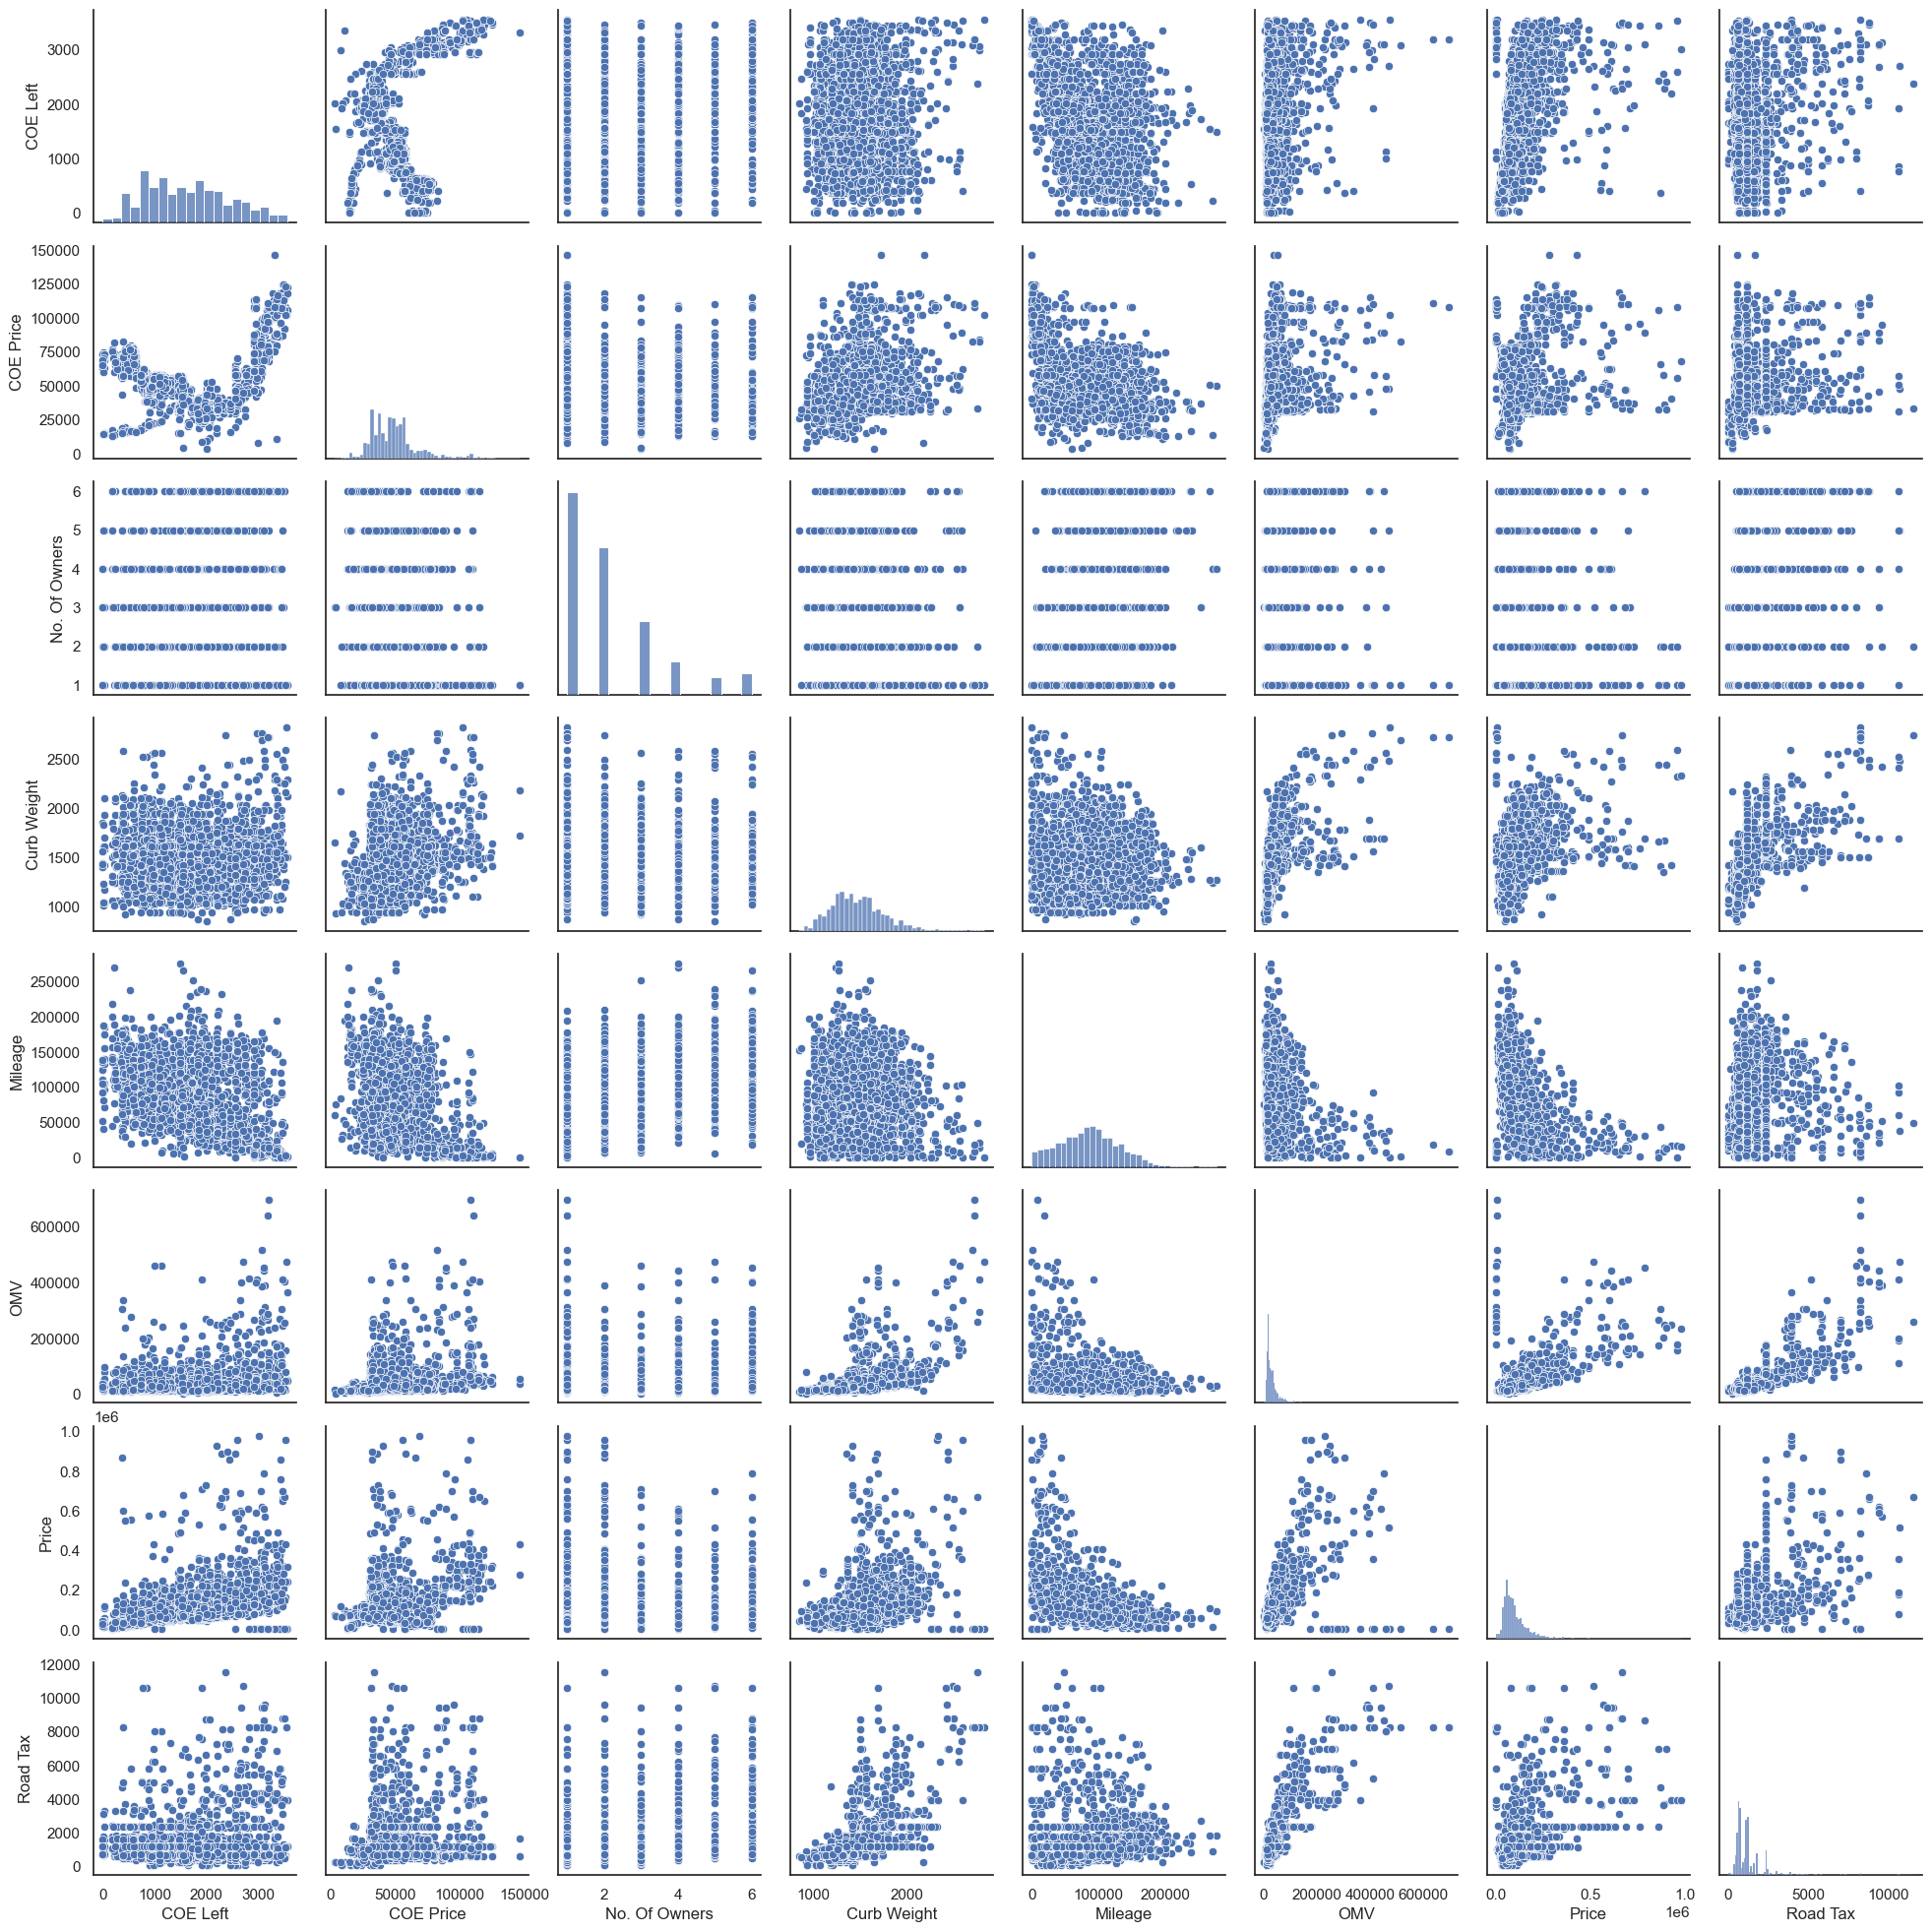

In [139]:
# ML selected variables
sns.pairplot(selected_X);

/var/folders/bf/d3x6nd1n1_q1_sxrfpb42_ch0000gn/T/ipykernel_97756/2392374282.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.DataFrame.hist(selected_X,ax=ax)


array([[<Axes: title={'center': 'COE Left'}>,
        <Axes: title={'center': 'COE Price'}>,
        <Axes: title={'center': 'No. Of Owners'}>],
       [<Axes: title={'center': 'Curb Weight'}>,
        <Axes: title={'center': 'Mileage'}>,
        <Axes: title={'center': 'OMV'}>],
       [<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Road Tax'}>, <Axes: >]], dtype=object)

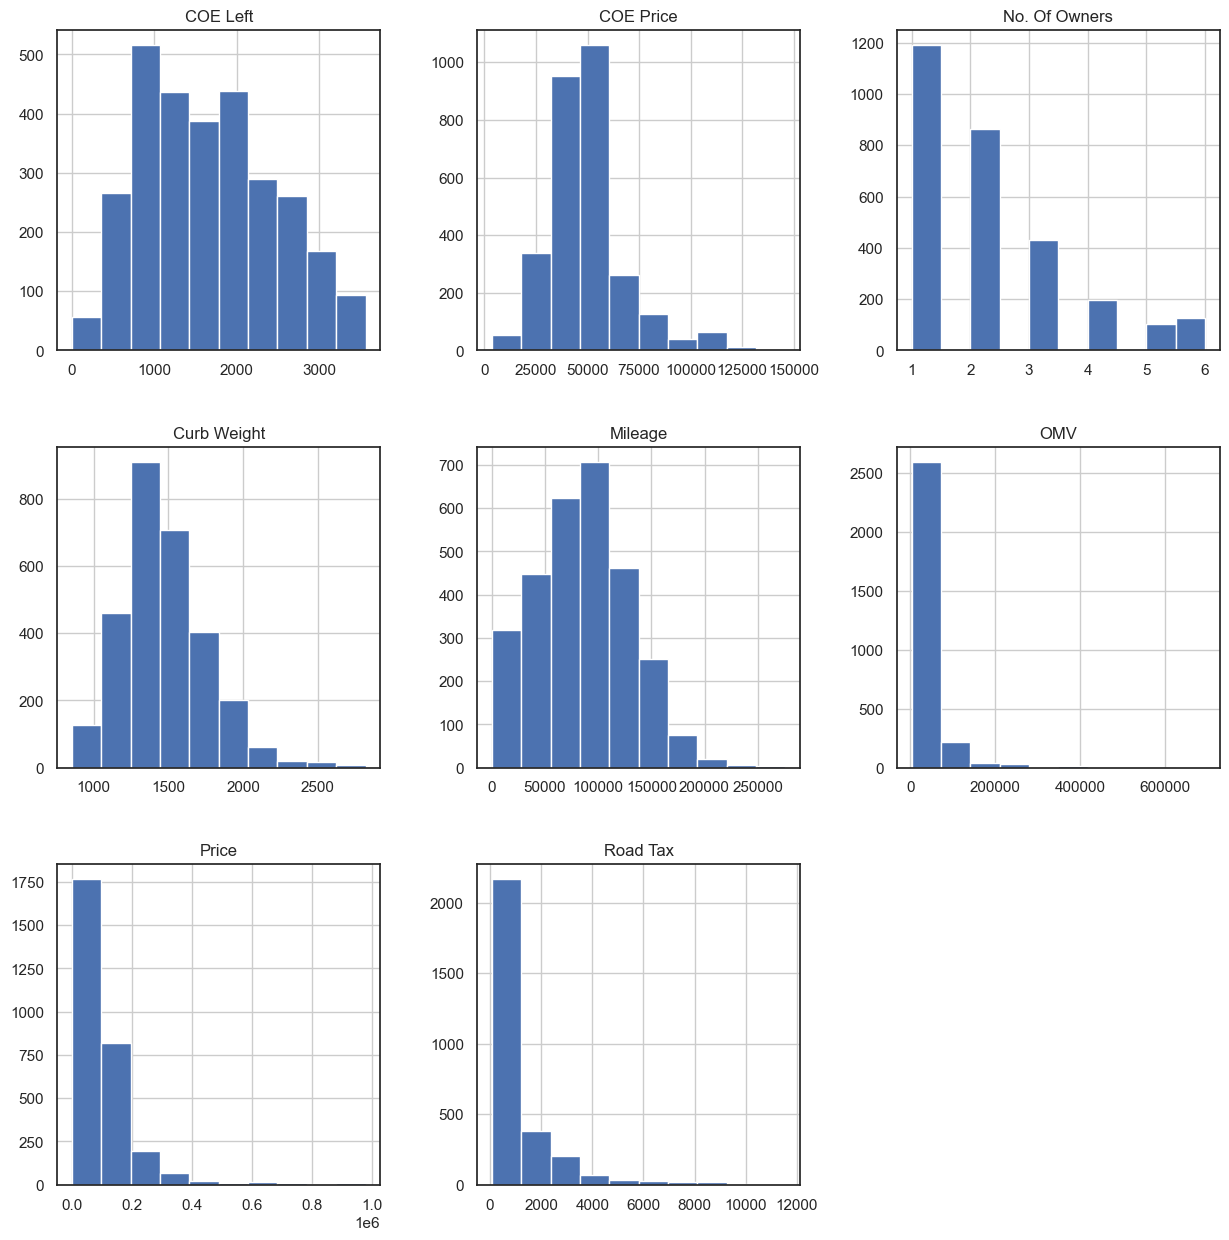

In [140]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
pd.DataFrame.hist(selected_X,ax=ax)

In [141]:
import numpy as np

data_rm_brand_only_OMV_logged = data_rm_brand.copy().drop(columns=['Transmission','Deregistration','Vehicle Type'], axis=1)
data_rm_brand_only_OMV_logged['OMV'] = np.log(data_rm_brand_only_OMV_logged['OMV'])
data_rm_brand_only_OMV_logged.head()
data_rm_brand_only_OMV_logged.to_csv('OMV_columns.csv', index=False)


In [142]:
import numpy as np

data_rm_brand_only_curbweight_logged = data_rm_brand.copy().drop(columns=['Transmission','Deregistration','Vehicle Type'], axis=1)
data_rm_brand_only_curbweight_logged['Curb Weight'] = np.log(data_rm_brand_only_curbweight_logged['Curb Weight'])
data_rm_brand_only_curbweight_logged.head()
data_rm_brand_only_curbweight_logged.to_csv('Curb_Weight_columns.csv', index=False)

In [143]:
import numpy as np

data_rm_brand_only_roadtax_logged = data_rm_brand.copy().drop(columns=['Transmission','Deregistration','Vehicle Type'], axis=1)
data_rm_brand_only_roadtax_logged['Road Tax'] = np.log(data_rm_brand_only_roadtax_logged['Road Tax'])
data_rm_brand_only_roadtax_logged.head()
data_rm_brand_only_roadtax_logged.to_csv('Road_Tax_columns.csv', index=False)

In [144]:
import numpy as np


data_rm_brand_only_COE_logged = data_rm_brand.copy().drop(columns=['Transmission','Deregistration','Vehicle Type'], axis=1)
data_rm_brand_only_COE_logged['COE Price'] = np.log(data_rm_brand_only_COE_logged['COE Price'])
data_rm_brand_only_COE_logged.head()
data_rm_brand_only_COE_logged.to_csv('COE_Price_columns.csv', index=False)

In [145]:
import numpy as np

data_rm_brand_only_owners_logged = data_rm_brand.copy().drop(columns=['Transmission','Deregistration','Vehicle Type'], axis=1)
data_rm_brand_only_owners_logged['No. Of Owners'] = np.log(data_rm_brand_only_owners_logged['No. Of Owners'])
data_rm_brand_only_owners_logged.head()
data_rm_brand_only_owners_logged.to_csv('No_Of_Owners_columns.csv', index=False)

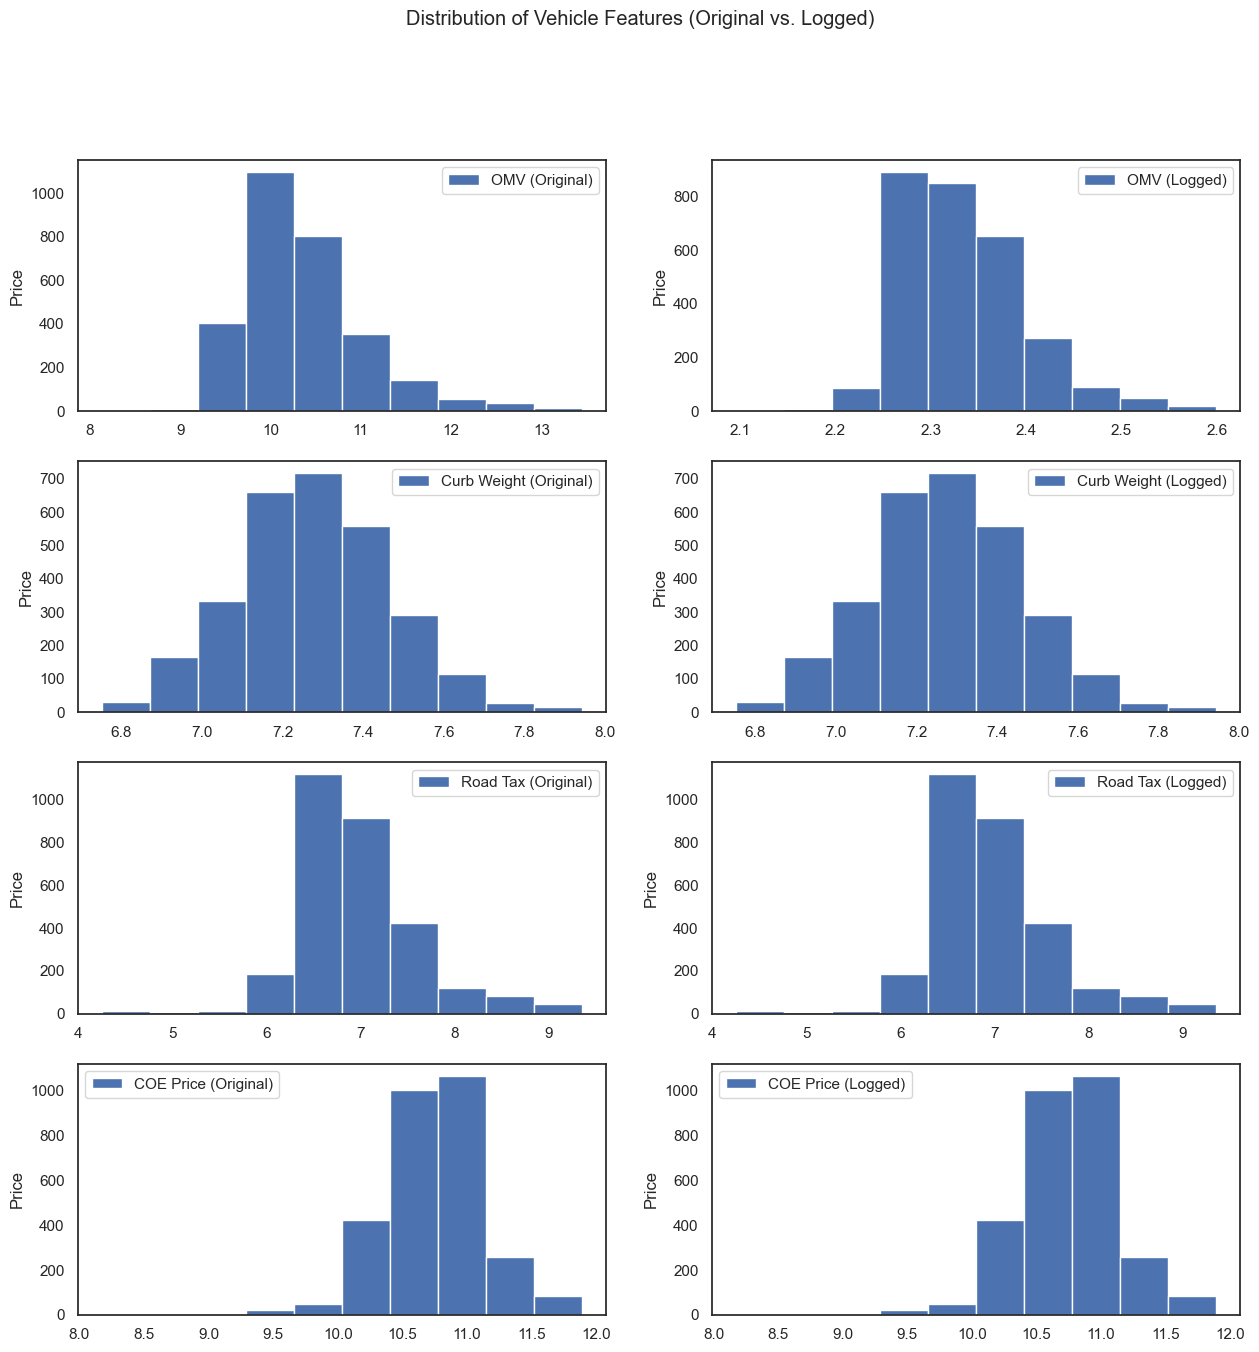

In [146]:
# **Import the Pandas DataFrame class**
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Logged Histogram

data_rm_brand_only_OMV_logged = pd.read_csv('OMV_columns.csv')
data_rm_brand_only_curbweight_logged = pd.read_csv('Curb_Weight_columns.csv')
data_rm_brand_only_roadtax_logged = pd.read_csv('Road_Tax_columns.csv')
data_rm_brand_only_COE_logged = pd.read_csv('COE_Price_columns.csv')

# Log-transform the data**
logged_data = {}
for column in ['OMV', 'Curb Weight', 'Road Tax', 'COE Price']:
    logged_data[column] = np.log(data_rm_brand_only_OMV_logged[column])

# Create a figure and axes object
fig, axs = plt.subplots(4, 2, figsize=(15,15))

# Plot the histograms
axs[0, 0].hist(data_rm_brand_only_OMV_logged['OMV'], label='OMV (Original)')
axs[0, 1].hist(logged_data['OMV'], label='OMV (Logged)')
axs[1, 0].hist(data_rm_brand_only_curbweight_logged['Curb Weight'], label='Curb Weight (Original)')
axs[1, 1].hist(logged_data['Curb Weight'], label='Curb Weight (Logged)')
axs[2, 0].hist(data_rm_brand_only_roadtax_logged['Road Tax'], label='Road Tax (Original)')
axs[2, 1].hist(logged_data['Road Tax'], label='Road Tax (Logged)')
axs[3, 0].hist(data_rm_brand_only_COE_logged['COE Price'], label='COE Price (Original)')
axs[3, 1].hist(logged_data['COE Price'], label='COE Price (Logged)')

# Add titles and labels
plt.suptitle('Distribution of Vehicle Features (Original vs. Logged)')
for ax in axs.ravel():
    ax.set_xlabel(ax.get_title())
    ax.set_ylabel('Price')
    ax.legend()

# Show the plot
plt.show()


In [147]:
import pandas as pd

# Read the two CSV files into Pandas DataFrames
df1 = pd.read_csv('OMV_columns.csv')
df2 = pd.read_csv('Curb_Weight_columns.csv')

# Merge the two DataFrames into a single DataFrame
df = pd.concat([df1, df2], ignore_index=True)

# Save the merged DataFrame to a new CSV file
df.to_csv('merged_logging.csv', index=False)


In [148]:
import pandas as pd

# Read the three CSV files into Pandas DataFrames
df1 = pd.read_csv('OMV_columns.csv')
df2 = pd.read_csv('Curb_Weight_columns.csv')
df3 = pd.read_csv('Road_Tax_columns.csv')

# Merge the three DataFrames into a single DataFrame
df = pd.concat([df1, df2, df3], ignore_index=True)

# Save the merged DataFrame to a new CSV file
df.to_csv('merged_logging2.csv', index=False)


In [149]:
import pandas as pd

# Read the four CSV files into Pandas DataFrames
df1 = pd.read_csv('OMV_columns.csv')
df2 = pd.read_csv('Curb_Weight_columns.csv')
df3 = pd.read_csv('Road_Tax_columns.csv')
df4 = pd.read_csv('COE_Price_columns.csv')

# Merge the four DataFrames into a single DataFrame
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Save the merged DataFrame to a new CSV file
df.to_csv('merged_logging3.csv', index=False)


In [150]:
import pandas as pd

# Read the five CSV files into Pandas DataFrames
df1 = pd.read_csv('OMV_columns.csv')
df2 = pd.read_csv('Curb_Weight_columns.csv')
df3 = pd.read_csv('Road_Tax_columns.csv')
df4 = pd.read_csv('COE_Price_columns.csv')
df5 = pd.read_csv('No_Of_Owners_columns.csv')

# Merge the five DataFrames into a single DataFrame
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

# Save the merged DataFrame to a new CSV file
df.to_csv('merged_logging4.csv', index=False)

In [151]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging.csv')
data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.4237040833008491


In [152]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging2.csv')
data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.4728773751843721


In [153]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging3.csv')
data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.4467930600385769


In [154]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging4.csv')
data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.43375367036277246


In [155]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

R2 score: 0.853434388701281


/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [156]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging2.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.9110143012328817


/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

In [157]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging3.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

R2 score: 0.9161549089104304


/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [158]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging4.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)



/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

R2 score: 0.9156574398048849


/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


In [159]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.8157914965239015


In [160]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging2.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.8888730310971142


In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging3.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.8927033409913808


In [162]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging4.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.9063251741650378


In [163]:
import pandas as pd
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#CROSS-VALIDATION for all 3 models
# Load your dataset
data = pd.read_csv('merged_logging4.csv')

# Define your features (X) and the target (y)
X = data.drop(['Price'], axis=1)  # Features
y = data['Price']  # Target variable

# Create an XGBoost / Linear / RandomForrest regressor
model = xgb.XGBRegressor()
model2 = LinearRegression()
model3 = RandomForestRegressor()

# Perform 5-fold cross-validation and calculate R2 scores
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
scores2 = cross_val_score(model2, X, y, cv=5, scoring='r2')
scores3 = cross_val_score(model3, X, y, cv=5, scoring='r2')

# Print the R2 scores for each fold
print('XGBRegressor Cross-Validation R2 scores:', scores)
print('LinearRegression Cross-Validation R2 scores:', scores2)
print('RandomForestRegressor Cross-Validation R2 scores:', scores3)

# Calculate and print the mean R2 score and standard deviation
mean_r2_xgb = scores.mean()
std_r2_xgb = scores.std()
print('XGBRegressor Mean R2:', mean_r2_xgb)
print('XGBRegressor Standard Deviation of R2:', std_r2_xgb)

mean_r2_linearR = scores2.mean()
std_r2_linearR = scores2.std()
print('LinearRegression Mean R2:', mean_r2_linearR)
print('LinearRegression Standard Deviation of R2:', std_r2_linearR)

mean_r2_randomf = scores3.mean()
std_r2_randomf = scores3.std()
print('RandomForestRegressor Mean R2:', mean_r2_randomf)
print('RandomForestRegressor Standard Deviation of R2:', std_r2_randomf)

/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

XGBRegressor Cross-Validation R2 scores: [0.04788376 0.74292074 0.84416435 0.78959246 0.95804782]
LinearRegression Cross-Validation R2 scores: [ 0.3157695  -0.29312606  0.41929493  0.48189321  0.44169043]
RandomForestRegressor Cross-Validation R2 scores: [0.05808731 0.58705017 0.94085075 0.94017679 0.98435604]
XGBRegressor Mean R2: 0.676521826739158
XGBRegressor Standard Deviation of R2: 0.32240983328864037
LinearRegression Mean R2: 0.27310440072771774
LinearRegression Standard Deviation of R2: 0.2883827068321472
RandomForestRegressor Mean R2: 0.7021042125253307
RandomForestRegressor Standard Deviation of R2: 0.3525165980639131
